# Harmonic Balance

In [303]:
import sympy as sp
sp.init_printing()
import numpy as np
from scipy.optimize import fsolve  # You can also use newton_krylov for larger systems
import matplotlib.pyplot as plt

## Define the symbols and constants

variables: $y, y_1$ for the vertical displacement, $t$ for time

In [304]:
t = sp.symbols('t')
y = sp.Function('y')(t)
y1 = sp.Function('y_1')(t)

Define other model constants:

$c_{a1}$ and $c_{a3}$ are the first and third term of the aerodynamic force

In [305]:
m, c, ca1, ca3, k1, k2, P, omega = sp.symbols('m c c_a1 c_a3 k_1 k_2 P omega')

the term $P \cdot \cos(\omega t)$ is the forcing term used in the *Harmonic Balance*

In [306]:
forcing_term = P * sp.cos(omega * t)

## Define the ansatz terms

$$
\begin{cases}
y &= Q_{c1} \cos (\omega t) + Q_{s1} \sin ( \omega t) \\
y_1 &= Q_{c2} \cos (\omega t) + Q_{s2} \sin ( \omega t) \\
\end{cases}
$$

In [307]:
Qc1, Qs1, Qc2, Qs2 = sp.symbols('Qc1 Qs1 Qc2 Qs2')

Define the ansatz functions for $y$ and $y_1$

In [308]:
y_ansatz = Qc1 * sp.cos(omega * t) + Qs1 * sp.sin(omega * t)
y1_ansatz = Qc2 * sp.cos(omega * t) + Qs2 * sp.sin(omega * t)

Compute the derivatives

In [309]:
y_ansatz_dt = sp.diff(y_ansatz, t)
y_ansatz_dt2 = sp.diff(y_ansatz_dt, t)
y1_ansatz_dt = sp.diff(y1_ansatz, t)
y1_ansatz_dt2 = sp.diff(y1_ansatz_dt, t)

## Substitute the ansatz functions and their derivatives into the equations

Select the model to be analyzed:

In [310]:
Maxwell = False
SLS_Maxwell = True
SLS_Kelvin = False

### Maxwell model:

$$
\begin{cases}
m \ddot{y} +(c-c_{a1}) \cdot \dot{y} -c \dot{y}_1 -c_{a3} \dot{y}^3  &= P cos (\omega t) \\
c \cdot (\dot{y}_1 - \dot{y}) + k_2 y &= 0
\end{cases}
$$

In [311]:
if Maxwell:
    eq1_substituted = sp.Eq(m * y_ansatz_dt2 + (c - ca1) * y_ansatz_dt -c * y1_ansatz_dt -ca3 * y_ansatz_dt ** 3 - forcing_term, 0)
    eq2_substituted = sp.Eq(c * ( y1_ansatz_dt - y_ansatz_dt) + k2* y1_ansatz, 0)

### SLS Maxwell model:

$$
\begin{cases}
m \ddot{y} -c_{a1} \dot{y} -c_{a3} \dot{y}^3 + (k_1 + k_2) y -k_2 y_1 &= P cos (\omega t) \\
c \dot{y}_1 + k_2 ( y_1 - y ) &= 0
\end{cases}
$$

In [312]:
if SLS_Maxwell:
    eq1_substituted = sp.Eq(m * y_ansatz_dt2 - ca1 * y_ansatz_dt -ca3 * y_ansatz_dt ** 3 + (k1 + k2) * y_ansatz - k2 * y1_ansatz - forcing_term, 0)
    eq2_substituted = sp.Eq(c * y1_ansatz_dt + k2 * ( y1_ansatz - y_ansatz ), 0)

### SLS Kelvin model:

$$
\begin{cases}
m \ddot{y} -c_{a1} \dot{y} -c_{a3} \dot{y}^3 + k_1 \cdot ( y - y_1) &= P cos (\omega t) \\
c \dot{y}_1 + k_2  y_1 + k_1 \cdot ( y_1 - y ) &= 0
\end{cases}
$$

In [313]:
if SLS_Kelvin:
    eq1_substituted = sp.Eq(m * y_ansatz_dt2 - ca1 * y_ansatz_dt -ca3 * y_ansatz_dt ** 3 + k1 * ( y_ansatz - y1_ansatz ) - forcing_term, 0)
    eq2_substituted = sp.Eq(c * y1_ansatz_dt + k1 * ( y1_ansatz - y_ansatz ) +  k2 * y1_ansatz, 0)

Manually expand the cubic term using trigonometric identities

In [314]:
y_dt_cubed = sp.expand(y_ansatz_dt**3)
y_dt_cubed_expanded = y_dt_cubed.subs({
    sp.cos(omega * t)**3: (3 * sp.cos(omega * t) + sp.cos(3 * omega * t)) / 4,
    sp.sin(omega * t)**3: (3 * sp.sin(omega * t) - sp.sin(3 * omega * t)) / 4,
    sp.cos(omega * t) * sp.sin(omega * t)**2: (sp.sin(omega * t) - sp.sin(3 * omega * t)) / 4,
    sp.sin(omega * t) * sp.cos(omega * t)**2: (sp.sin(omega * t) + sp.sin(3 * omega * t)) / 4,
})

Substitute back the expanded cubic term

In [315]:
eq1_manual_expand = eq1_substituted.subs(y_ansatz_dt**3, y_dt_cubed_expanded)
eq1_manual_expand

In [316]:
eq2_expanded = sp.expand_trig(eq2_substituted)
eq2_expanded

Use *trigsimp* to further simplify trigonometric expressions (probably not necessary)

In [317]:
eq1_simplified = sp.trigsimp(eq1_manual_expand, recursive=True)
eq2_simplified = sp.trigsimp(eq2_expanded, recursive=True)

Further expand all terms so that it is easier to collect harmonics

In [318]:
eq1_simplified = sp.expand(eq1_simplified)
eq1_simplified

In [319]:
eq2_simplified = sp.expand(eq2_simplified)
eq2_simplified

Extract the right-hand sides of the equations (not necessary if we have put everything on the LHS)

In [320]:
rhs_eq1 = eq1_simplified.rhs - eq1_simplified.lhs
rhs_eq2 = eq2_simplified.rhs - eq2_simplified.lhs

Collect terms involving $\cos(n \cdot \omega t)$ and $\sin(n \cdot \omega t)$

In [321]:
harmonics = [sp.cos(n * omega * t) for n in range(1, 4)] + [sp.sin(n * omega * t) for n in range(1, 4)]
harmonics

Collect *harmonics*

In [322]:
collected_rhs_eq1 = sp.collect(rhs_eq1, harmonics, evaluate=False)
collected_rhs_eq2 = sp.collect(rhs_eq2, harmonics, evaluate=False)

## Display the results

In [323]:
collected_rhs_eq1

In [324]:
collected_rhs_eq2

We **neglect** the *harmonics* higher than the *ansatz* and we balance the Harmonics:

$$
\begin{cases}
\left[ R_{c1} \right] \cdot \cos (\omega t) &= 0 \\
\left[ R_{s1} \right] \cdot \sin (\omega t) &= 0 \\
\left[ R_{c2} \right] \cdot \cos (\omega t) &= 0 \\
\left[ R_{s2} \right] \cdot \sin (\omega t) &= 0
\end{cases}
$$

We arrive to a system of 4 equations in the 4 unknowns $Q_{c1}, Q_{s1}, Q_{c2}, Q_{s2}$ and 2 parameters, $P, \omega$

In [325]:
sys_1st_order = [collected_rhs_eq1[sp.cos(omega*t)],
                 collected_rhs_eq1[sp.sin(omega*t)],
                 collected_rhs_eq2[sp.cos(omega*t)],
                 collected_rhs_eq2[sp.sin(omega*t)]]
sys_1st_order

We define the variables:

In [326]:
variables = [Qc1, Qs1, Qc2, Qs2]

We compute the *Jacobian Matrix* in order to solve the non-linear system of equations

In [327]:
jacobian_matrix = sp.Matrix(sys_1st_order).jacobian(variables)
jacobian_matrix

⎡                                                                             
⎢                                   2                                      9⋅Q
⎢                     -k₁ - k₂ + m⋅ω                                       ───
⎢                                                                             
⎢                                                                             
⎢       2      3                  3        2      3               2      3    
⎢  9⋅Qc₁ ⋅cₐ₃⋅ω    3⋅Qc₁⋅Qs₁⋅cₐ₃⋅ω    3⋅Qs₁ ⋅cₐ₃⋅ω           3⋅Qc₁ ⋅cₐ₃⋅ω    3
⎢- ───────────── + ──────────────── - ───────────── - cₐ₁⋅ω  ───────────── - ─
⎢        4                2                 4                      4          
⎢                                                                             
⎢                            k₂                                               
⎢                                                                             
⎣                            0                      

## Convert to NumPy functions

In [328]:
system_func = sp.lambdify((Qc1, Qs1, Qc2, Qs2, m, c, ca1, ca3, k1, k2, P, omega), sys_1st_order, modules='numpy')
jacobian_func = sp.lambdify((Qc1, Qs1, Qc2, Qs2, m, c, ca1, ca3, k1, k2, P, omega), jacobian_matrix, modules='numpy')

Define constants

In [329]:
mr   = 5.0
dens = 1.0
D    = 1.0
mu   = 0.01
Re   = 200.0
UR   = 40.0
ma   = 3.5
ma   = 0.0

F0   = 0.1
ws   = 0.94

xi = 0.1
R  = 1

U = Re*mu/dens/D
w = 2.0*np.pi*U/UR/D

m_val = mr*dens*D*D
k_val = w**2*m_val
c_val = 2.0*m_val*w*xi * 0.001

print(k_val)
print(c_val)

0.4934802200544679
0.0003141592653589793


Aerodynamic terms

In [330]:
# Re 120
#cd0 = 1.4101832657353157
#cd_alpha2 = 20.38624222765305
#cl_alpha = -1.149546065899541
#cl_alpha3 = 139.61145345153142

# Re 200
cd0 = 1.4301607330629407
cd_alpha2 = 31.3338614210225
cl_alpha = -2.8618111944401288
cl_alpha3 = 376.0747841613836

A = cl_alpha - cd0
B = -cl_alpha + cl_alpha3/3 + cd0/3 - cd_alpha2
ca1comp = -0.5*dens*D*U*A
ca3comp = -0.5*dens*D/U * (2/3*A+B/2)

print(ca1comp)
print(ca3comp)

4.291971927503069
-11.45503777102863


In [331]:
omega_vect = np.linspace(0, 20, num= 200)
sol_vect = np.zeros_like(omega_vect)
int_vect = np.zeros_like(omega_vect)

# Provide an initial guess for x (4 variables)
initial_guess = np.array([0.0, 0.0, 0.0, 0.0])  # Replace with your initial guess values

for i, curr_omega in enumerate(omega_vect):

    curr_P = 0.1
    # Define your parameter values (these are your literal parameters in sympy)
    params = (m_val, c_val, ca1comp, ca3comp, k_val, k_val*R, curr_P, curr_omega)  # replace with actual parameter values

    # Define a wrapper for the function f(x) = 0
    def func_to_solve(x):
        res = system_func(x[0], x[1], x[2], x[3], *params)
        #print(res)
        return res

    # Optionally define a wrapper for the Jacobian, if available
    def jacobian_func_final(x):
        res = jacobian_func(x[0], x[1], x[2], x[3], *params)
        #print(res)
        return res

    # Solve using fsolve
    solution = fsolve(func_to_solve, initial_guess, fprime=jacobian_func_final)

    # Output the solution
    # print("Solution: ", solution)

    sol_vect[i] = np.sqrt(solution[0]**2 + solution[1]**2)
    int_vect[i] = np.sqrt(solution[2]**2 + solution[3]**2)

    initial_guess = solution
    # You can check the residual to verify if the solution is correct
    #residual = func_to_solve(solution)
    #print("Residual: ", residual)



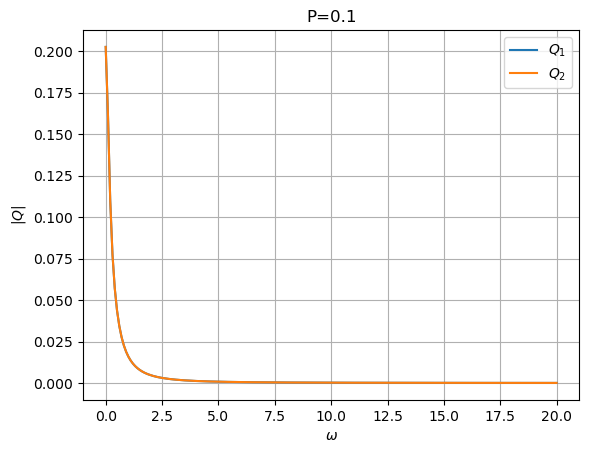

In [332]:
plt.figure()
plt.plot(omega_vect, sol_vect, label='$Q_1$')
plt.plot(omega_vect, int_vect, label='$Q_2$')
plt.xlabel(r"$\omega$")
plt.ylabel(r"$|Q|$")
plt.title("P={0}".format(curr_P))
plt.legend()
plt.grid()
plt.savefig('Q.png')